In [1]:
import tensorflow as tf

from keras.layers import Conv2D,DepthwiseConv2D,GlobalAveragePooling2D,BatchNormalization,Input,Reshape,Dropout,Activation
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from keras.layers.advanced_activations import ReLU
import matplotlib.pyplot as plt


In [2]:
# Config variables
# Data images are not of the same size
INPUT_SIZE = [224, 224]
BATCH = 32

In [3]:
# No data augmentation
train_val_image_data_generator = ImageDataGenerator(rescale=1.0/255,
                                            rotation_range=20,
                                            zoom_range=0.2,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            shear_range=0.2,
                                            horizontal_flip=True,
                                            fill_mode="nearest",
                                            validation_split=0.2
                                            )

train_data = train_val_image_data_generator.flow_from_directory('./data/',
                                                     target_size = INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     classes=['with_mask','without_mask'],
                                                     subset='training',
                                                     shuffle=True
                                                     )
validate_data = train_val_image_data_generator.flow_from_directory('./data/',
                                                     target_size = INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     classes=['with_mask','without_mask'],
                                                     subset='validation',
                                                     shuffle=True
                                                     )

Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [4]:
def depth_point_conv2d(x,s=[1,1,2,1],channel=[64,128]):
    """
    s:the strides of the conv
    channel: the depth of pointwiseconvolutions
    """
    
    dw1 = DepthwiseConv2D((3,3),strides=s[0],padding='same')(x)
    bn1 = BatchNormalization()(dw1)
    relu1 = ReLU()(bn1)
    pw1 = Conv2D(channel[0],(1,1),strides=s[1],padding='same')(relu1)
    bn2 = BatchNormalization()(pw1)
    relu2 = ReLU()(bn2)
    dw2 = DepthwiseConv2D((3,3),strides=s[2],padding='same')(relu2)
    bn3 = BatchNormalization()(dw2)
    relu3 = ReLU()(bn3)
    pw2 = Conv2D(channel[1],(1,1),strides=s[3],padding='same')(relu3)
    bn4 = BatchNormalization()(pw2)
    relu4 = ReLU()(bn4)
    
    return relu4
    
def repeat_conv(x,s=[1,1],channel=512):
    dw1 = DepthwiseConv2D((3,3),strides=s[0],padding='same')(x)
    bn1 = BatchNormalization()(dw1)
    relu1 = ReLU()(bn1)
    pw1 = Conv2D(channel,(1,1),strides=s[1],padding='same')(relu1)
    bn2 = BatchNormalization()(pw1)
    relu2 = ReLU()(bn2)
    
    return relu2
    


In [5]:
dropout=0.5
h0=Input(shape=(224,224,3))
h1=Conv2D(32,(3,3),strides = 2,padding="same")(h0)
h2= BatchNormalization()(h1)
h3=ReLU()(h2)
h4 = depth_point_conv2d(h3,s=[1,1,2,1],channel=[64,128])
h5 = depth_point_conv2d(h4,s=[1,1,2,1],channel=[128,256])
h6 = depth_point_conv2d(h5,s=[1,1,2,1],channel=[256,512])
h7 = repeat_conv(h6)
h8 = repeat_conv(h7)
h9 = repeat_conv(h8)
h10 = repeat_conv(h9)
h11 = repeat_conv(h10)
h12 = depth_point_conv2d(h10,s=[2,1,2,1],channel=[512,1024])
h13 = GlobalAveragePooling2D()(h12)
h14 = Reshape((1, 1, 1024), name='reshape_1')(h13)
h15 = Dropout(dropout, name='dropout')(h14)
h16 = Conv2D(2, (1, 1),padding='same', name='conv_preds')(h15)

h17 = Activation('softmax', name='act_softmax')(h16)
h18 = Reshape((2,), name='reshape_2')(h17)
model =Model(h0,h18,name='ModlieNet')


model.summary()




Model: "ModlieNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 112, 112, 32)      0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 112, 112, 32)      0 

In [6]:
model.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])


In [7]:
es = EarlyStopping(monitor="accuracy", patience=20, verbose=1, mode="auto")

model = model.fit( train_data, validation_data=validate_data,epochs=25, steps_per_epoch=len(train_data),validation_steps=len(validate_data),callbacks=[es])


Epoch 1/25
 25/189 [==>...........................] - ETA: 46s - loss: 0.7712 - accuracy: 0.5300

d:\software\anaconda\anaconda\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 [==============================] - 93s 449ms/step - loss: 0.6248 - accuracy: 0.6606 - val_loss: 0.7314 - val_accuracy: 0.5066
Epoch 2/25
189/189 [==============================] - 60s 317ms/step - loss: 0.4557 - accuracy: 0.7902 - val_loss: 0.7602 - val_accuracy: 0.5066
Epoch 3/25
189/189 [==============================] - 60s 317ms/step - loss: 0.3696 - accuracy: 0.8403 - val_loss: 0.6531 - val_accuracy: 0.5232
Epoch 4/25
189/189 [==============================] - 59s 310ms/step - loss: 0.2982 - accuracy: 0.8736 - val_loss: 0.3160 - val_accuracy: 0.8662
Epoch 5/25
189/189 [==============================] - 60s 315ms/step - loss: 0.2583 - accuracy: 0.8860 - val_loss: 0.2056 - val_accuracy: 0.9152
Epoch 6/25
189/189 [==============================] - 60s 317ms/step - loss: 0.2404 - accuracy: 0.8981 - val_loss: 0.3656 - val_accuracy: 0.8371
Epoch 7/25
189/189 [==============================] - 60s 315ms/step - loss: 0.2146 - accuracy: 0.9130 - val_loss: 0.2779 - val_accuracy: 0.8

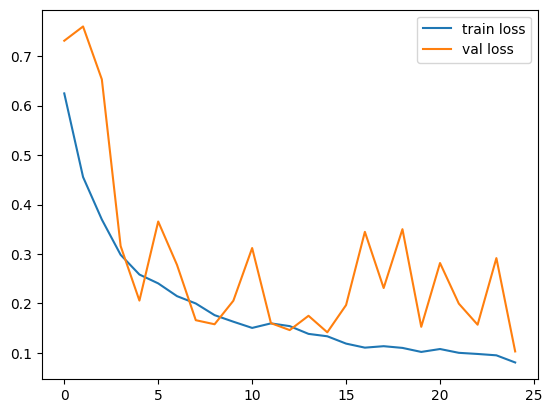

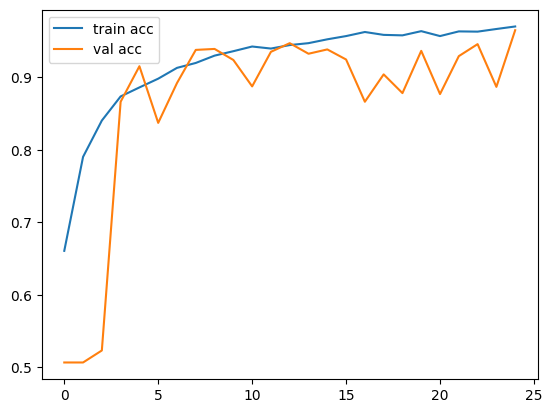

In [8]:
plt.plot(model.history['loss'], label='train loss')
plt.plot(model.history['val_loss'], label='val loss')
plt.legend()
plt.show()


# plot the accuracy
plt.plot(model.history['accuracy'], label='train acc')
plt.plot(model.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
